In [6]:
# 1
# 导入必要的库
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import time
from datetime import datetime

# 设置随机种子，确保结果可复现
np.random.seed(42)
tf.random.set_seed(42)

# 设置GPU内存增长
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# 创建输出目录
OUTPUT_DIR = './mlp'
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("TensorFlow版本:", tf.__version__)
print("Keras版本:", tf.keras.__version__)
print("GPU是否可用:", tf.config.list_physical_devices('GPU'))

TensorFlow版本: 2.12.0
Keras版本: 2.12.0
GPU是否可用: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
# 2
# 辅助函数：加载数据
def load_data(binary=True):
    """
    加载预处理过的数据
    
    参数:
    binary (bool): 是否加载二分类数据集，如果为False则加载多分类数据集
    
    返回:
    训练集、验证集和测试集的特征和标签
    """
    data_dir = '/root/autodl-tmp/projects/DL/dataset/feature_engineering'
    
    if binary:
        print("加载二分类数据集...")
        # 加载训练集（平衡后）
        train_data = joblib.load(os.path.join(data_dir, 'binary_train_balanced.joblib'))
        X_train, y_train = train_data['X_train'], train_data['y_train']
        
        # 加载验证集
        val_data = joblib.load(os.path.join(data_dir, 'binary_val.joblib'))
        X_val, y_val = val_data['X_val'], val_data['y_val']
        
        # 加载测试集
        test_data = joblib.load(os.path.join(data_dir, 'binary_test.joblib'))
        X_test, y_test = test_data['X_test'], test_data['y_test']
        
        # 加载特征列表
        feature_list = joblib.load(os.path.join(data_dir, 'feature_list.joblib'))
        
        print(f"训练集: X形状 {X_train.shape}, y形状 {y_train.shape}")
        print(f"验证集: X形状 {X_val.shape}, y形状 {y_val.shape}")
        print(f"测试集: X形状 {X_test.shape}, y形状 {y_test.shape}")
        
        return X_train, y_train, X_val, y_val, X_test, y_test, feature_list
    else:
        print("加载多分类数据集...")
        # 加载训练集（平衡后）
        train_data = joblib.load(os.path.join(data_dir, 'multi_train_balanced.joblib'))
        X_train, y_train = train_data['X_train'], train_data['y_train']
        
        # 加载验证集
        val_data = joblib.load(os.path.join(data_dir, 'multi_val.joblib'))
        X_val, y_val = val_data['X_val'], val_data['y_val']
        
        # 加载测试集
        test_data = joblib.load(os.path.join(data_dir, 'multi_test.joblib'))
        X_test, y_test = test_data['X_test'], test_data['y_test']
        
        # 加载特征列表和标签映射
        feature_list = joblib.load(os.path.join(data_dir, 'feature_list.joblib'))
        label_mapping = joblib.load(os.path.join(data_dir, 'label_mapping.joblib'))
        
        # 获取类别数量
        num_classes = len(label_mapping)
        
        # 将标签转换为one-hot编码
        y_train = to_categorical(y_train, num_classes=num_classes)
        y_val = to_categorical(y_val, num_classes=num_classes)
        y_test = to_categorical(y_test, num_classes=num_classes)
        
        print(f"训练集: X形状 {X_train.shape}, y形状 {y_train.shape}")
        print(f"验证集: X形状 {X_val.shape}, y形状 {y_val.shape}")
        print(f"测试集: X形状 {X_test.shape}, y形状 {y_test.shape}")
        print(f"类别数量: {num_classes}")
        
        return X_train, y_train, X_val, y_val, X_test, y_test, feature_list, label_mapping

# 绘制混淆矩阵
def plot_confusion_matrix(y_true, y_pred, class_names=None, figsize=(10, 8), title='混淆矩阵'):
    """
    绘制混淆矩阵
    
    参数:
    y_true: 真实标签
    y_pred: 预测标签
    class_names: 类别名称
    figsize: 图形大小
    title: 图表标题
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('预测标签')
    plt.ylabel('真实标签')
    plt.title(title)
    plt.tight_layout()
    
    # 保存图像
    plt.savefig(os.path.join(OUTPUT_DIR, f'confusion_matrix_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'), dpi=300)
    plt.show()

# 绘制ROC曲线(二分类)
def plot_roc_curve(y_true, y_pred_proba, figsize=(10, 8)):
    """
    绘制ROC曲线(二分类)
    
    参数:
    y_true: 真实标签
    y_pred_proba: 预测概率
    figsize: 图形大小
    """
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=figsize)
    plt.plot(fpr, tpr, lw=2, label=f'ROC曲线 (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('假阳性率')
    plt.ylabel('真阳性率')
    plt.title('ROC曲线')
    plt.legend(loc="lower right")
    
    # 保存图像
    plt.savefig(os.path.join(OUTPUT_DIR, f'roc_curve_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'), dpi=300)
    plt.show()
    
    return roc_auc

# 绘制多类别的ROC曲线
def plot_multiclass_roc(y_test, y_pred_proba, class_names, figsize=(12, 10)):
    """
    绘制多类别的ROC曲线
    
    参数:
    y_test: 测试集标签 (one-hot编码)
    y_pred_proba: 预测概率
    class_names: 类别名称
    figsize: 图形大小
    """
    n_classes = len(class_names)
    
    # 将one-hot编码转换回类别索引
    if len(y_test.shape) > 1 and y_test.shape[1] > 1:
        y_test_class = np.argmax(y_test, axis=1)
    else:
        y_test_class = y_test
        
    plt.figure(figsize=figsize)
    
    # 计算每个类别的ROC曲线
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        # 二分类方式：一个类别对其他所有类别
        y_test_bin = (y_test_class == i).astype(int)
        fpr[i], tpr[i], _ = roc_curve(y_test_bin, y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
        # 绘制每个类别的ROC曲线
        plt.plot(fpr[i], tpr[i], lw=2, 
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')
    
    # 绘制随机猜测的曲线
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('假阳性率', fontsize=12)
    plt.ylabel('真阳性率', fontsize=12)
    plt.title('多类别ROC曲线', fontsize=14)
    plt.legend(loc="lower right", fontsize=10)
    
    # 保存图像
    plt.savefig(os.path.join(OUTPUT_DIR, f'multiclass_roc_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'), dpi=300)
    plt.show()
    
    # 计算宏平均AUC
    macro_roc_auc = np.mean(list(roc_auc.values()))
    print(f"宏平均ROC AUC: {macro_roc_auc:.4f}")
    
    return roc_auc, macro_roc_auc

# 绘制学习曲线
def plot_learning_curves(history, figsize=(12, 5)):
    """
    绘制模型的学习曲线
    
    参数:
    history: 模型训练历史
    figsize: 图形大小
    """
    plt.figure(figsize=figsize)
    
    # 绘制损失曲线
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='训练损失')
    plt.plot(history.history['val_loss'], label='验证损失')
    plt.title('模型损失曲线')
    plt.xlabel('Epoch')
    plt.ylabel('损失')
    plt.legend()
    
    # 绘制准确率曲线
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='训练准确率')
    plt.plot(history.history['val_accuracy'], label='验证准确率')
    plt.title('模型准确率曲线')
    plt.xlabel('Epoch')
    plt.ylabel('准确率')
    plt.legend()
    
    plt.tight_layout()
    
    # 保存图像
    plt.savefig(os.path.join(OUTPUT_DIR, f'learning_curves_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'), dpi=300)
    plt.show()

In [8]:
# 3
# 加载二分类数据
X_train, y_train, X_val, y_val, X_test, y_test, feature_list = load_data(binary=True)

# 检查数据类型并转换为numpy数组(如果是DataFrame)
if isinstance(X_train, pd.DataFrame):
    X_train = X_train.values
    X_val = X_val.values
    X_test = X_test.values

if isinstance(y_train, pd.Series):
    y_train = y_train.values
    y_val = y_val.values
    y_test = y_test.values

# 显示前几个样本
print("\n前5个训练样本特征:")
print(X_train[:5])
print("\n前5个训练样本标签:")
print(y_train[:5])

# 检查数据集的分布
print("\n训练集标签分布:")
unique, counts = np.unique(y_train, return_counts=True)
for i, (u, c) in enumerate(zip(unique, counts)):
    print(f"类别 {u}: {c} 样本 ({c/len(y_train)*100:.2f}%)")

print("\n验证集标签分布:")
unique, counts = np.unique(y_val, return_counts=True)
for i, (u, c) in enumerate(zip(unique, counts)):
    print(f"类别 {u}: {c} 样本 ({c/len(y_val)*100:.2f}%)")

print("\n测试集标签分布:")
unique, counts = np.unique(y_test, return_counts=True)
for i, (u, c) in enumerate(zip(unique, counts)):
    print(f"类别 {u}: {c} 样本 ({c/len(y_test)*100:.2f}%)")

加载二分类数据集...
训练集: X形状 (3156363, 70), y形状 (3156363,)
验证集: X形状 (424611, 70), y形状 (424611,)
测试集: X形状 (424612, 70), y形状 (424612,)

前5个训练样本特征:
[[ 9.30769231e-01  4.10008196e+00  9.66666667e+00  6.66666667e+00
   1.64153409e+02  2.26680498e+01  1.75066667e+01  8.33333333e-01
   2.04538116e+01  2.29065774e+01  4.53928571e+00  3.50649351e-01
   2.37669516e+00  8.03108098e+00 -9.33989722e-03 -4.51603804e-03
   7.15965488e-01  2.58388470e+00  5.27060602e+00 -4.91803279e-02
   1.06600988e+01  2.14395807e+00  3.55811215e+01  1.39588604e+01
  -4.16666667e-02  1.32687468e+02  3.42399066e+01  1.78645101e+02
   2.14404748e+02  2.22222222e-02  0.00000000e+00  0.00000000e+00
   1.08500000e+01  6.90476190e+00 -4.89081742e-03 -2.46714721e-03
   6.94444444e-01  2.42884615e+00  6.22635551e+00  3.52306251e+00
   1.34554666e+01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -1.00000000e+00  4.98561633e+00  2.04538116e+01
   2.

In [9]:
# 4
def create_mlp_model(input_dim, binary=True, hidden_layers=[256, 128, 64, 32], dropout_rate=0.3):
    """
    创建基础MLP模型
    
    参数:
    input_dim: 输入特征的维度
    binary: 是否为二分类模型
    hidden_layers: 隐藏层的神经元数量列表
    dropout_rate: Dropout比率
    
    返回:
    构建好的MLP模型
    """
    model = Sequential()
    
    # 添加输入层
    model.add(Dense(hidden_layers[0], input_dim=input_dim, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # 添加隐藏层
    for units in hidden_layers[1:]:
        model.add(Dense(units, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
    
    # 添加输出层
    if binary:
        model.add(Dense(1, activation='sigmoid'))  # 二分类
        loss = 'binary_crossentropy'
        metrics = ['accuracy']
    else:
        model.add(Dense(8, activation='softmax'))  # 多分类 (8个类别)
        loss = 'categorical_crossentropy'
        metrics = ['accuracy']
    
    # 编译模型
    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss=loss,
        metrics=metrics
    )
    
    return model

# 创建模型
input_dim = X_train.shape[1]  # 特征数量
model = create_mlp_model(input_dim=input_dim, binary=True)

# 打印模型摘要
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 256)               18176     
                                                                 
 batch_normalization_4 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_5 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 128)              

In [ ]:
# 4.5
# 显示TensorFlow将使用的设备
import tensorflow as tf
print("TensorFlow将使用的设备:")
print(tf.config.list_physical_devices())

# 检查默认设备
with tf.device('/gpu:0'):
    a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
    b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
    c = tf.matmul(a, b)
    print("操作执行设备:", c.device)
    print("运算结果:", c)

# 检查是否可以访问GPU
if tf.test.is_gpu_available():
    print("GPU可用")
else:
    print("没有可用的GPU")

In [10]:
# 5
# 启用设备放置日志
tf.debugging.set_log_device_placement(True)  

# 定义回调函数
callbacks = [
    # 提前停止
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        verbose=1,
        restore_best_weights=True
    ),
    # 模型检查点
    ModelCheckpoint(
        filepath=os.path.join(OUTPUT_DIR, 'best_mlp_model.h5'),
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    # 学习率调度器
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        verbose=1,
        min_lr=1e-6
    )
]

# 训练模型
batch_size = 128
epochs = 50

print(f"开始训练模型...\n批大小: {batch_size}, 最大epochs: {epochs}")
start_time = time.time()

history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

training_time = time.time() - start_time
print(f"模型训练完成! 总耗时: {training_time:.2f}秒")

# 保存最终模型
model.save(os.path.join(OUTPUT_DIR, f'final_mlp_model_{datetime.now().strftime("%Y%m%d_%H%M%S")}.h5'))

开始训练模型...
批大小: 128, 最大epochs: 50
Epoch 1/50
24657/24660 [============================>.] - ETA: 0s - loss: 0.0912 - accuracy: 0.9676
Epoch 1: val_loss improved from inf to 100.47681, saving model to ./deep_learning_models/best_mlp_model.h5
24660/24660 [==============================] - 233s 9ms/step - loss: 0.0912 - accuracy: 0.9676 - val_loss: 100.4768 - val_accuracy: 0.9594 - lr: 0.0010
Epoch 2/50
24658/24660 [============================>.] - ETA: 0s - loss: 0.0604 - accuracy: 0.9806
Epoch 2: val_loss improved from 100.47681 to 77.35020, saving model to ./deep_learning_models/best_mlp_model.h5
24660/24660 [==============================] - 229s 9ms/step - loss: 0.0604 - accuracy: 0.9806 - val_loss: 77.3502 - val_accuracy: 0.9671 - lr: 0.0010
Epoch 3/50
24654/24660 [============================>.] - ETA: 0s - loss: 0.0548 - accuracy: 0.9821
Epoch 3: val_loss improved from 77.35020 to 12.61420, saving model to ./deep_learning_models/best_mlp_model.h5
24660/24660 [=====================

/tmp/ipykernel_51559/3760516639.py:207: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_51559/3760516639.py:207: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_51559/3760516639.py:207: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_51559/3760516639.py:207: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_51559/3760516639.py:207: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_51559/3760516639.py:207: UserWarning: Glyph 32447 (\N{CJK UNIFIED IDEOGRAPH-7EBF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_51559/3760516639.py:207: UserWarning: Glyph 35757 (\N{CJK UNIFIED I

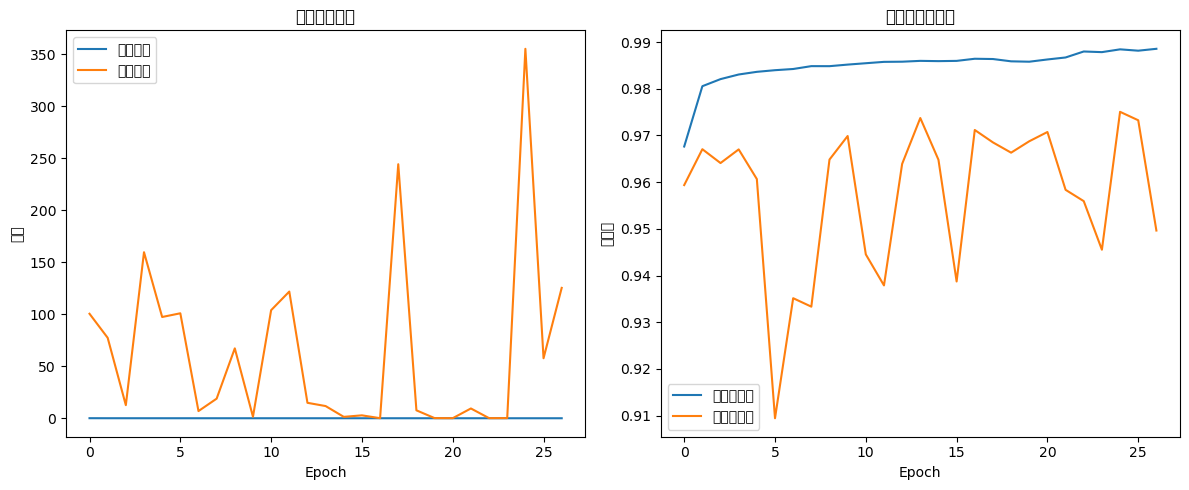

最佳模型在第 17 个epoch:
验证损失: 0.0944
验证准确率: 0.9712


In [11]:
# 6
# 绘制学习曲线
plot_learning_curves(history)

# 找出验证损失最低的epoch
best_epoch = np.argmin(history.history['val_loss']) + 1
best_val_loss = np.min(history.history['val_loss'])
best_val_acc = history.history['val_accuracy'][best_epoch-1]

print(f"最佳模型在第 {best_epoch} 个epoch:")
print(f"验证损失: {best_val_loss:.4f}")
print(f"验证准确率: {best_val_acc:.4f}")

在测试集上评估模型性能...
13270/13270 [==============================] - 23s 2ms/step
测试集准确率: 0.9714
测试集F1分数: 0.9248

混淆矩阵:
[[337649   3316]
 [  8846  74801]]

分类报告:
              precision    recall  f1-score   support

          正常       0.97      0.99      0.98    340965
          攻击       0.96      0.89      0.92     83647

    accuracy                           0.97    424612
   macro avg       0.97      0.94      0.95    424612
weighted avg       0.97      0.97      0.97    424612



/root/miniconda3/envs/sl-nsl-env/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/root/miniconda3/envs/sl-nsl-env/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 24120 (\N{CJK UNIFIED IDEOGRAPH-5E38}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/root/miniconda3/envs/sl-nsl-env/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 25915 (\N{CJK UNIFIED IDEOGRAPH-653B}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/root/miniconda3/envs/sl-nsl-env/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 20987 (\N{CJK UNIFIED IDEOGRAPH-51FB}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/tmp/ipykernel_51559/3760516639.py:88: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_51559/3760516639.py:88: UserWarning: Glyph 27979 (\N{

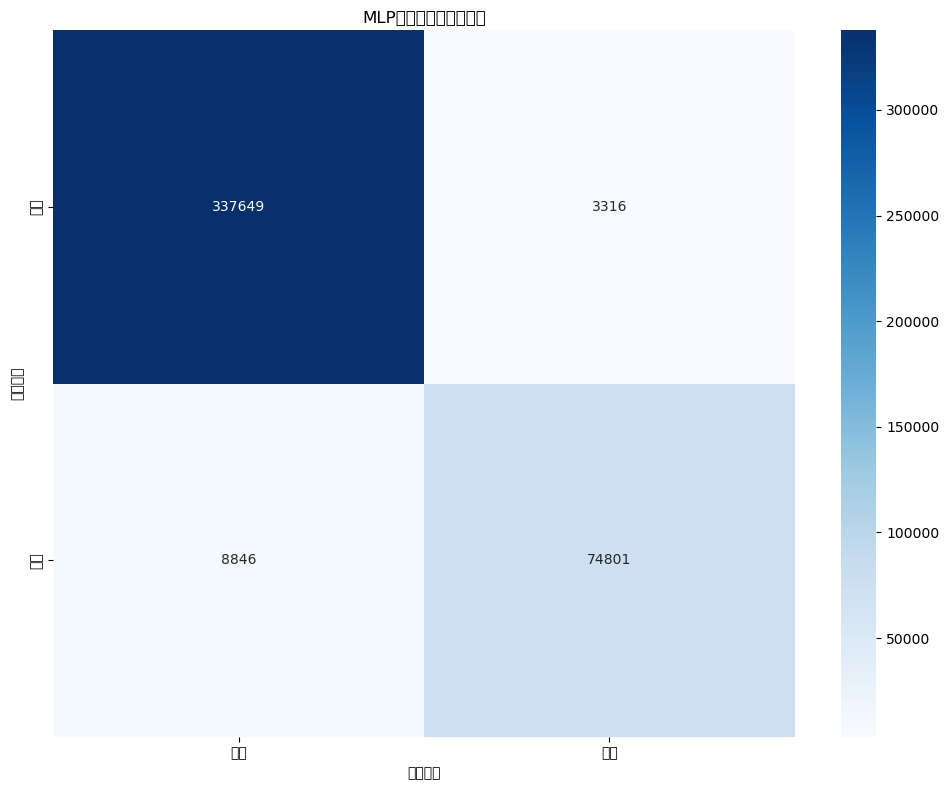

/tmp/ipykernel_51559/3760516639.py:118: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) DejaVu Sans.
  plt.savefig(os.path.join(OUTPUT_DIR, f'roc_curve_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'), dpi=300)
/tmp/ipykernel_51559/3760516639.py:118: UserWarning: Glyph 38451 (\N{CJK UNIFIED IDEOGRAPH-9633}) missing from font(s) DejaVu Sans.
  plt.savefig(os.path.join(OUTPUT_DIR, f'roc_curve_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'), dpi=300)
/tmp/ipykernel_51559/3760516639.py:118: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from font(s) DejaVu Sans.
  plt.savefig(os.path.join(OUTPUT_DIR, f'roc_curve_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'), dpi=300)
/tmp/ipykernel_51559/3760516639.py:118: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  plt.savefig(os.path.join(OUTPUT_DIR, f'roc_curve_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'), dpi=300)
/tmp/ipykernel_51559/3760516639.

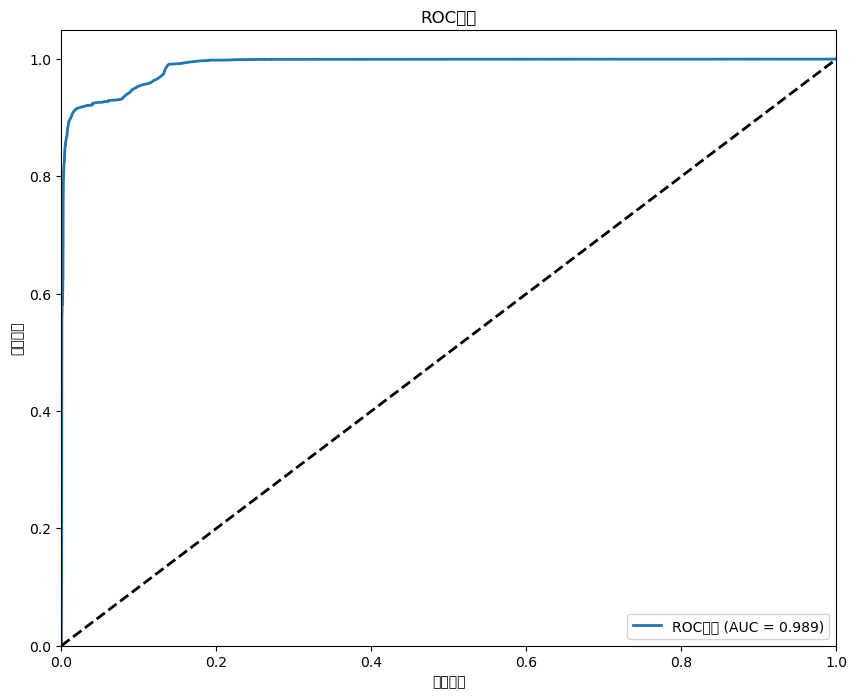

ROC曲线下面积(AUC): 0.9893


In [12]:
# 7
# 在测试集上评估模型
print("在测试集上评估模型性能...")

# 获取预测概率
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()  # 二分类阈值为0.5

# 计算评估指标
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cf_matrix = confusion_matrix(y_test, y_pred)

print(f"测试集准确率: {accuracy:.4f}")
print(f"测试集F1分数: {f1:.4f}")
print("\n混淆矩阵:")
print(cf_matrix)

# 输出分类报告
print("\n分类报告:")
print(classification_report(y_test, y_pred, target_names=['正常', '攻击']))

# 绘制混淆矩阵
plot_confusion_matrix(y_test, y_pred, class_names=['正常', '攻击'], title='MLP模型测试集混淆矩阵')

# 绘制ROC曲线
roc_auc = plot_roc_curve(y_test, y_pred_proba)
print(f"ROC曲线下面积(AUC): {roc_auc:.4f}")

寻找最佳决策阈值...
最佳阈值: 0.5040
该阈值下的F1分数: 0.9248
最佳阈值下的准确率: 0.9714
最佳阈值下的F1分数: 0.9248


/tmp/ipykernel_51559/426333836.py:37: UserWarning: Glyph 31934 (\N{CJK UNIFIED IDEOGRAPH-7CBE}) missing from font(s) DejaVu Sans.
  plt.savefig(os.path.join(OUTPUT_DIR, f'precision_recall_curve_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'), dpi=300)
/tmp/ipykernel_51559/426333836.py:37: UserWarning: Glyph 30830 (\N{CJK UNIFIED IDEOGRAPH-786E}) missing from font(s) DejaVu Sans.
  plt.savefig(os.path.join(OUTPUT_DIR, f'precision_recall_curve_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'), dpi=300)
/tmp/ipykernel_51559/426333836.py:37: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  plt.savefig(os.path.join(OUTPUT_DIR, f'precision_recall_curve_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'), dpi=300)
/tmp/ipykernel_51559/426333836.py:37: UserWarning: Glyph 21484 (\N{CJK UNIFIED IDEOGRAPH-53EC}) missing from font(s) DejaVu Sans.
  plt.savefig(os.path.join(OUTPUT_DIR, f'precision_recall_curve_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'

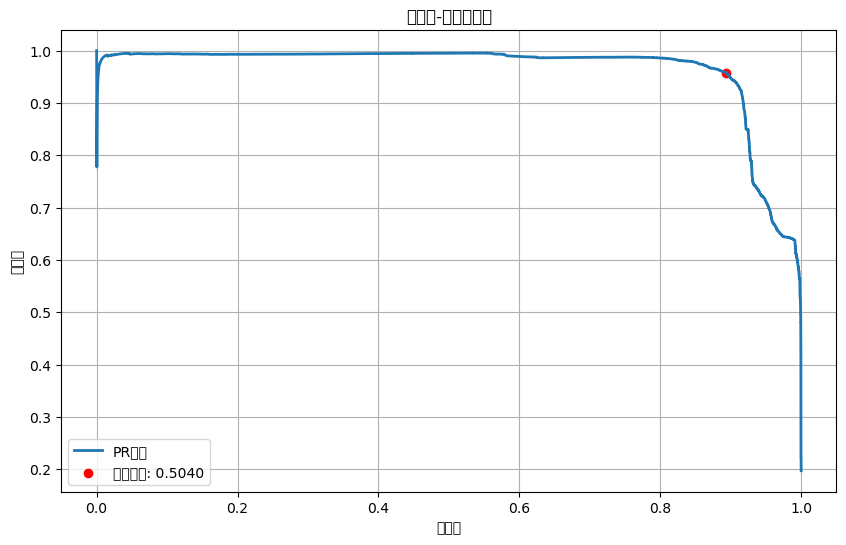


最佳阈值下的分类报告:
              precision    recall  f1-score   support

          正常       0.97      0.99      0.98    340965
          攻击       0.96      0.89      0.92     83647

    accuracy                           0.97    424612
   macro avg       0.97      0.94      0.95    424612
weighted avg       0.97      0.97      0.97    424612



/root/miniconda3/envs/sl-nsl-env/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/root/miniconda3/envs/sl-nsl-env/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 24120 (\N{CJK UNIFIED IDEOGRAPH-5E38}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/root/miniconda3/envs/sl-nsl-env/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 25915 (\N{CJK UNIFIED IDEOGRAPH-653B}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/root/miniconda3/envs/sl-nsl-env/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 20987 (\N{CJK UNIFIED IDEOGRAPH-51FB}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/tmp/ipykernel_51559/3760516639.py:88: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_51559/3760516639.py:88: UserWarning: Glyph 27979 (\N{

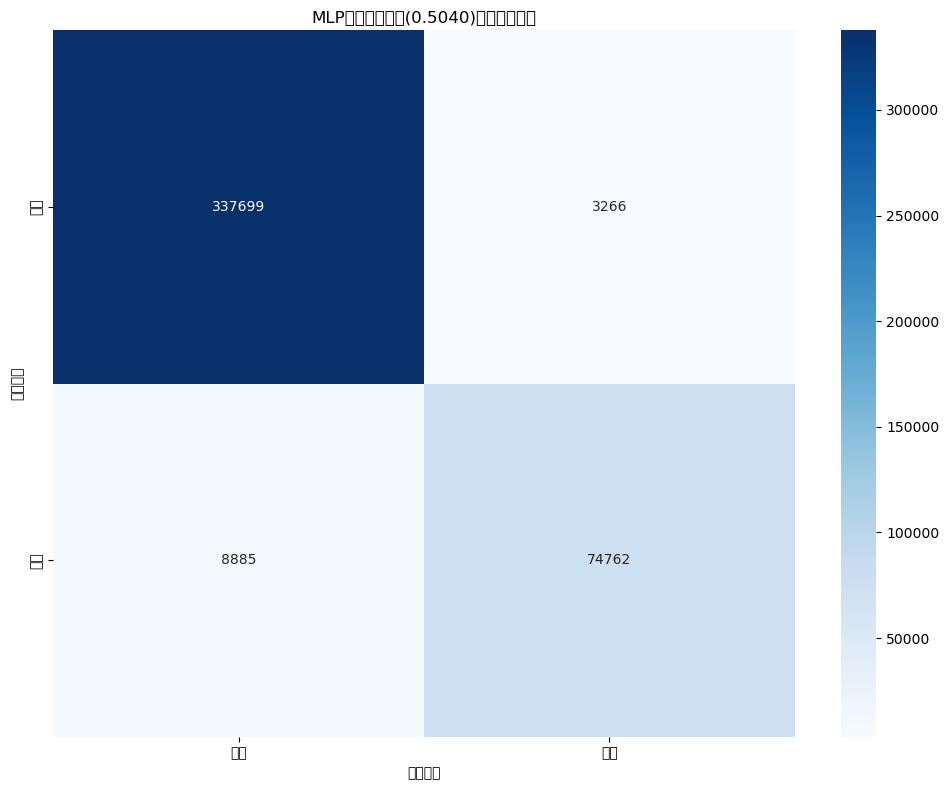

In [13]:
# 8
# 寻找最佳阈值
print("寻找最佳决策阈值...")

# 计算不同阈值下的精确率和召回率
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)

# 计算F1分数
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-7)

# 找到最佳F1分数对应的阈值
best_idx = np.argmax(f1_scores[:-1])  # 最后一个值没有对应的阈值
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"最佳阈值: {best_threshold:.4f}")
print(f"该阈值下的F1分数: {best_f1:.4f}")

# 使用最佳阈值重新计算预测
y_pred_best = (y_pred_proba > best_threshold).astype(int).flatten()
accuracy_best = accuracy_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)

print(f"最佳阈值下的准确率: {accuracy_best:.4f}")
print(f"最佳阈值下的F1分数: {f1_best:.4f}")

# 绘制精确率-召回率曲线
plt.figure(figsize=(10, 6))
plt.plot(recalls, precisions, lw=2, label='PR曲线')
plt.scatter(recalls[best_idx], precisions[best_idx], marker='o', color='red', 
            label=f'最佳阈值: {best_threshold:.4f}')
plt.xlabel('召回率')
plt.ylabel('精确率')
plt.title('精确率-召回率曲线')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(OUTPUT_DIR, f'precision_recall_curve_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'), dpi=300)
plt.show()

# 输出最佳阈值下的分类报告
print("\n最佳阈值下的分类报告:")
print(classification_report(y_test, y_pred_best, target_names=['正常', '攻击']))

# 绘制最佳阈值下的混淆矩阵
plot_confusion_matrix(y_test, y_pred_best, class_names=['正常', '攻击'], 
                      title=f'MLP模型最佳阈值({best_threshold:.4f})下的混淆矩阵')

分析特征重要性...
32/32 [==============================] - 0s 2ms/step


/tmp/ipykernel_51559/243818592.py:53: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_51559/243818592.py:53: UserWarning: Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_51559/243818592.py:53: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_51559/243818592.py:53: UserWarning: Glyph 35201 (\N{CJK UNIFIED IDEOGRAPH-8981}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_51559/243818592.py:53: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_51559/243818592.py:53: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_51559/243818592.py:53: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}

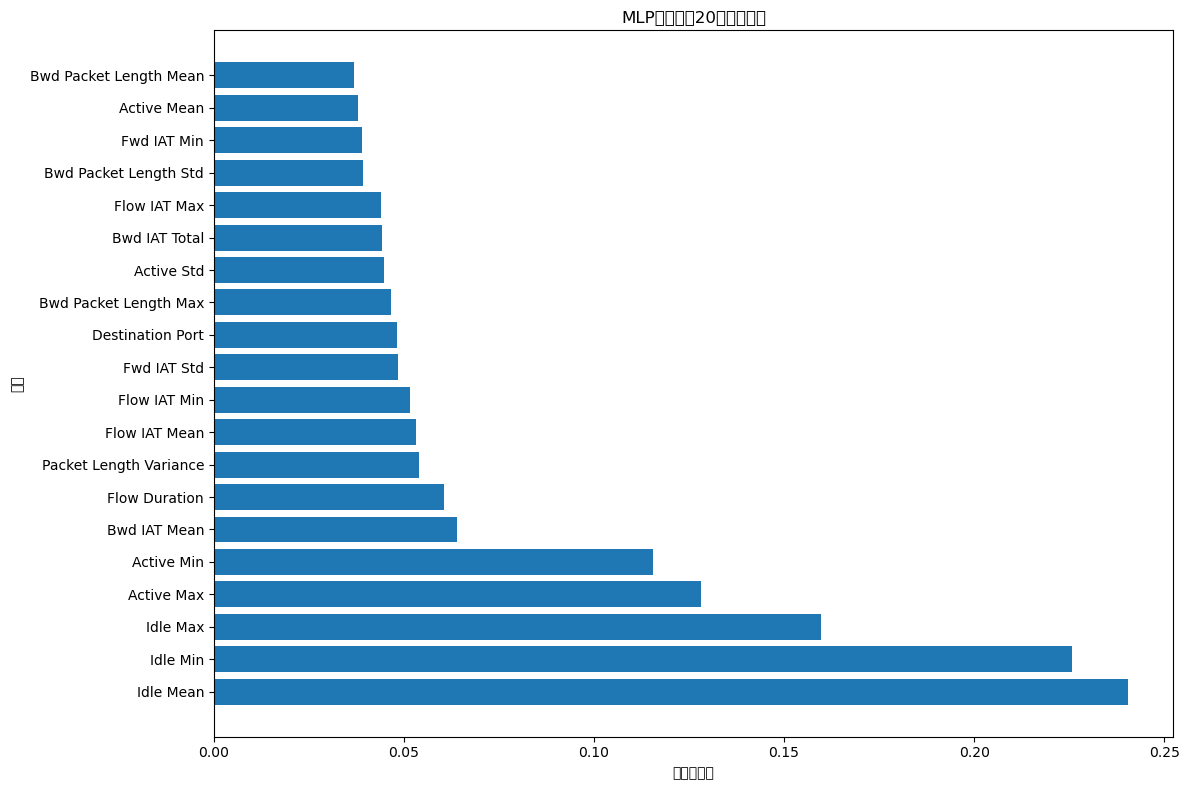


前20个重要特征:
1. Idle Mean: 0.240372
2. Idle Min: 0.225650
3. Idle Max: 0.159760
4. Active Max: 0.128089
5. Active Min: 0.115633
6. Bwd IAT Mean: 0.064074
7. Flow Duration: 0.060560
8. Packet Length Variance: 0.053879
9. Flow IAT Mean: 0.053179
10. Flow IAT Min: 0.051534
11. Fwd IAT Std: 0.048360
12. Destination Port: 0.048235
13. Bwd Packet Length Max: 0.046620
14. Active Std: 0.044748
15. Bwd IAT Total: 0.044180
16. Flow IAT Max: 0.044044
17. Bwd Packet Length Std: 0.039332
18. Fwd IAT Min: 0.038889
19. Active Mean: 0.037854
20. Bwd Packet Length Mean: 0.036794


In [14]:
# 9
# 分析特征重要性
def analyze_feature_importance(model, feature_names, top_n=20):
    """
    分析MLP模型的特征重要性
    
    参数:
    model: 训练好的模型
    feature_names: 特征名列表
    top_n: 显示前几个重要特征
    
    返回:
    特征重要性排序
    """
    # 创建一个临时的评估函数，通过观察每个特征扰动对输出的影响
    feature_importance = []
    
    # 从测试集中随机选择一部分样本
    n_samples = min(1000, X_test.shape[0])
    random_indices = np.random.choice(X_test.shape[0], n_samples, replace=False)
    X_subset = X_test[random_indices]
    
    # 获取基准预测
    base_prediction = model.predict(X_subset)
    
    # 为每个特征计算重要性
    for i, feature_name in enumerate(feature_names):
        # 创建扰动后的数据
        X_perturbed = X_subset.copy()
        X_perturbed[:, i] = np.random.permutation(X_perturbed[:, i])
        
        # 获取扰动后的预测
        perturbed_prediction = model.predict(X_perturbed)
        
        # 计算扰动影响(预测变化的平均绝对值)
        importance = np.mean(np.abs(base_prediction - perturbed_prediction))
        feature_importance.append((feature_name, importance))
    
    # 按重要性降序排序
    feature_importance.sort(key=lambda x: x[1], reverse=True)
    
    # 显示结果
    plt.figure(figsize=(12, 8))
    importance_values = [imp for _, imp in feature_importance[:top_n]]
    feature_names = [name for name, _ in feature_importance[:top_n]]
    
    # 绘制条形图
    plt.barh(range(len(importance_values)), importance_values, align='center')
    plt.yticks(range(len(importance_values)), feature_names)
    plt.xlabel('特征重要性')
    plt.ylabel('特征')
    plt.title(f'MLP模型的前{top_n}个重要特征')
    plt.tight_layout()
    
    # 保存图像
    plt.savefig(os.path.join(OUTPUT_DIR, f'feature_importance_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'), dpi=300)
    plt.show()
    
    return feature_importance

# 分析特征重要性
print("分析特征重要性...")
feature_importance = analyze_feature_importance(model, feature_list)

# 输出前20个重要特征
print("\n前20个重要特征:")
for i, (feature, importance) in enumerate(feature_importance[:20]):
    print(f"{i+1}. {feature}: {importance:.6f}")

使用t-SNE可视化测试集...
数据量较大，随机抽样5000个样本进行可视化...
执行t-SNE降维...


/root/miniconda3/envs/sl-nsl-env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE降维完成，耗时: 10.79秒


/tmp/ipykernel_51559/1114353328.py:41: UserWarning: Glyph 32500 (\N{CJK UNIFIED IDEOGRAPH-7EF4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_51559/1114353328.py:41: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_51559/1114353328.py:41: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_51559/1114353328.py:41: UserWarning: Glyph 35797 (\N{CJK UNIFIED IDEOGRAPH-8BD5}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_51559/1114353328.py:41: UserWarning: Glyph 38598 (\N{CJK UNIFIED IDEOGRAPH-96C6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_51559/1114353328.py:41: UserWarning: Glyph 21487 (\N{CJK UNIFIED IDEOGRAPH-53EF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_51559/1114353328.py:41: UserWarning: Glyph 35270 (\N{CJK UNIFIED IDEOGRAP

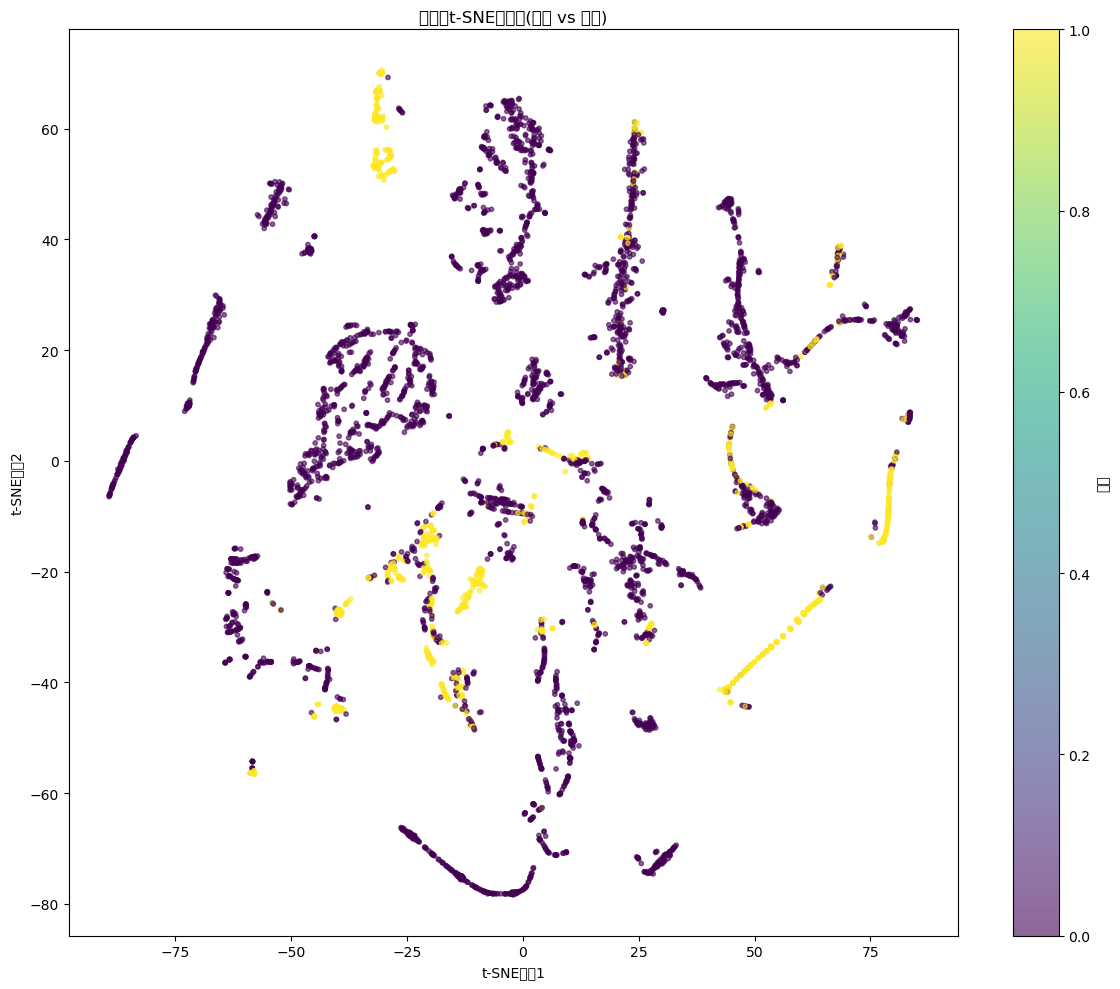

In [15]:
# 10
# 使用t-SNE可视化高维特征
from sklearn.manifold import TSNE

def visualize_tsne(X, y, perplexity=30, n_components=2, title="t-SNE可视化"):
    """
    使用t-SNE将高维特征可视化为2D
    
    参数:
    X: 特征数据
    y: 标签
    perplexity: t-SNE参数
    n_components: 降维后的维度
    title: 图表标题
    """
    # 随机抽样以提高性能(如果数据量太大)
    max_samples = 5000
    if X.shape[0] > max_samples:
        print(f"数据量较大，随机抽样{max_samples}个样本进行可视化...")
        indices = np.random.choice(X.shape[0], max_samples, replace=False)
        X_sample = X[indices]
        y_sample = y[indices]
    else:
        X_sample = X
        y_sample = y
    
    # 执行t-SNE降维
    print("执行t-SNE降维...")
    start_time = time.time()
    tsne = TSNE(n_components=n_components, perplexity=perplexity, n_iter=1000, random_state=42)
    X_tsne = tsne.fit_transform(X_sample)
    print(f"t-SNE降维完成，耗时: {time.time()-start_time:.2f}秒")
    
    # 可视化结果
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_sample, cmap='viridis', alpha=0.6, s=10)
    plt.colorbar(scatter, label='类别')
    plt.title(title)
    plt.xlabel('t-SNE维度1')
    plt.ylabel('t-SNE维度2')
    plt.tight_layout()
    
    # 保存图像
    plt.savefig(os.path.join(OUTPUT_DIR, f'tsne_visualization_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'), dpi=300)
    plt.show()
    
    return X_tsne

# 可视化测试集
print("使用t-SNE可视化测试集...")
X_tsne = visualize_tsne(X_test, y_test, title="测试集t-SNE可视化(正常 vs 攻击)")

测试模型推理速度...
1/1 [==============================] - 0s 20ms/step
批大小 1: 总时间 57.7552秒, 每批次 57.76毫秒, 每样本 57.76毫秒, 每秒样本数 17.3
1/1 [==============================] - 0s 19ms/step
批大小 8: 总时间 7.0981秒, 每批次 56.78毫秒, 每样本 7.10毫秒, 每秒样本数 140.9
1/1 [==============================] - 0s 19ms/step
批大小 32: 总时间 1.6264秒, 每批次 52.46毫秒, 每样本 1.63毫秒, 每秒样本数 614.9
2/2 [==============================] - 0s 3ms/step
批大小 64: 总时间 0.8305秒, 每批次 55.37毫秒, 每样本 0.83毫秒, 每秒样本数 1204.0
4/4 [==============================] - 0s 2ms/step
批大小 128: 总时间 0.4091秒, 每批次 58.44毫秒, 每样本 0.41毫秒, 每秒样本数 2444.4
8/8 [==============================] - 0s 2ms/step
批大小 256: 总时间 0.2144秒, 每批次 71.48毫秒, 每样本 0.21毫秒, 每秒样本数 4663.5


/tmp/ipykernel_51559/1643515039.py:70: UserWarning: Glyph 25209 (\N{CJK UNIFIED IDEOGRAPH-6279}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_51559/1643515039.py:70: UserWarning: Glyph 22823 (\N{CJK UNIFIED IDEOGRAPH-5927}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_51559/1643515039.py:70: UserWarning: Glyph 23567 (\N{CJK UNIFIED IDEOGRAPH-5C0F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_51559/1643515039.py:70: UserWarning: Glyph 27599 (\N{CJK UNIFIED IDEOGRAPH-6BCF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_51559/1643515039.py:70: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_51559/1643515039.py:70: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_51559/1643515039.py:70: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAP

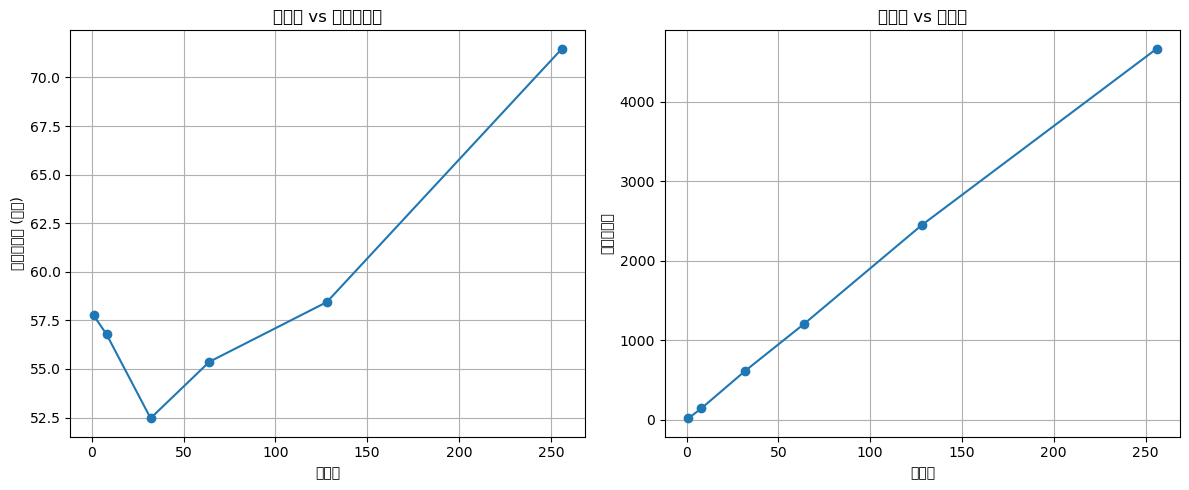

In [16]:
# 11
# 测试模型推理速度
def test_inference_speed(model, X, batch_sizes=[1, 8, 32, 64, 128, 256]):
    """
    测试模型在不同批大小下的推理速度
    
    参数:
    model: 训练好的模型
    X: 测试数据
    batch_sizes: 要测试的批大小列表
    """
    print("测试模型推理速度...")
    results = []
    
    for batch_size in batch_sizes:
        # 准备批次数据
        n_samples = min(1000, X.shape[0])
        n_batches = n_samples // batch_size
        
        # 随机选择样本
        random_indices = np.random.choice(X.shape[0], n_samples, replace=False)
        X_subset = X[random_indices]
        
        # 预热
        model.predict(X_subset[:batch_size])
        
        # 计时
        start_time = time.time()
        for i in range(n_batches):
            model.predict(X_subset[i*batch_size:(i+1)*batch_size])
        end_time = time.time()
        
        # 计算每批次和每样本的平均时间
        total_time = end_time - start_time
        avg_time_per_batch = total_time / n_batches
        avg_time_per_sample = total_time / n_samples
        
        results.append({
            'batch_size': batch_size,
            'total_time': total_time,
            'avg_time_per_batch': avg_time_per_batch,
            'avg_time_per_sample': avg_time_per_sample,
            'samples_per_second': n_samples / total_time
        })
        print(f"批大小 {batch_size}: 总时间 {total_time:.4f}秒, 每批次 {avg_time_per_batch*1000:.2f}毫秒, "
              f"每样本 {avg_time_per_sample*1000:.2f}毫秒, 每秒样本数 {n_samples/total_time:.1f}")
    
    # 可视化推理速度
    plt.figure(figsize=(12, 5))
    
    # 每批次时间
    plt.subplot(1, 2, 1)
    batch_sizes = [r['batch_size'] for r in results]
    batch_times = [r['avg_time_per_batch']*1000 for r in results]  # 转换为毫秒
    plt.plot(batch_sizes, batch_times, marker='o')
    plt.xlabel('批大小')
    plt.ylabel('每批次时间 (毫秒)')
    plt.title('批大小 vs 批处理时间')
    plt.grid(True)
    
    # 吞吐量
    plt.subplot(1, 2, 2)
    throughputs = [r['samples_per_second'] for r in results]
    plt.plot(batch_sizes, throughputs, marker='o')
    plt.xlabel('批大小')
    plt.ylabel('每秒样本数')
    plt.title('批大小 vs 吞吐量')
    plt.grid(True)
    
    plt.tight_layout()
    
    # 保存图像
    plt.savefig(os.path.join(OUTPUT_DIR, f'inference_speed_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'), dpi=300)
    plt.show()
    
    return results

# 测试推理速度
inference_speed_results = test_inference_speed(model, X_test)

In [17]:
# 12
# 实验: 不同网络架构的性能比较
def experiment_network_architectures():
    """
    实验不同网络架构的性能
    """
    print("实验: 不同网络架构的性能比较")
    
    # 定义不同的网络架构
    architectures = [
        {"name": "浅层网络", "layers": [128, 64]},
        {"name": "中等深度网络", "layers": [256, 128, 64]},
        {"name": "深层网络", "layers": [512, 256, 128, 64, 32]},
        {"name": "超深层网络", "layers": [512, 384, 256, 192, 128, 64, 32]}
    ]
    
    results = []
    
    for arch in architectures:
        print(f"\n测试架构: {arch['name']} - {arch['layers']}")
        
        # 创建模型
        model = create_mlp_model(input_dim=X_train.shape[1], binary=True, hidden_layers=arch['layers'])
        
        # 简化回调设置，以便更快训练
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        ]
        
        # 训练模型
        start_time = time.time()
        history = model.fit(
            X_train, y_train,
            batch_size=128,
            epochs=20,  # 减少epochs以加快实验
            validation_data=(X_val, y_val),
            callbacks=callbacks,
            verbose=1
        )
        training_time = time.time() - start_time
        
        # 评估模型
        y_pred_proba = model.predict(X_test)
        y_pred = (y_pred_proba > 0.5).astype(int).flatten()
        
        # 计算指标
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        # 保存结果
        best_epoch = np.argmin(history.history['val_loss']) + 1
        results.append({
            "architecture": arch['name'],
            "layers": arch['layers'],
            "accuracy": accuracy,
            "f1_score": f1,
            "training_time": training_time,
            "val_loss": np.min(history.history['val_loss']),
            "best_epoch": best_epoch,
            "params": model.count_params()
        })
        
        print(f"准确率: {accuracy:.4f}, F1分数: {f1:.4f}, 训练时间: {training_time:.2f}秒")
    
    # 转换为DataFrame以便于分析
    results_df = pd.DataFrame(results)
    print("\n实验结果摘要:")
    print(results_df[['architecture', 'accuracy', 'f1_score', 'training_time', 'val_loss', 'best_epoch', 'params']])
    
    # 可视化实验结果
    plt.figure(figsize=(15, 10))
    
    # 准确率和F1分数对比
    plt.subplot(2, 2, 1)
    plt.bar(results_df['architecture'], results_df['accuracy'], color='blue', alpha=0.6, label='准确率')
    plt.bar(results_df['architecture'], results_df['f1_score'], color='orange', alpha=0.6, label='F1分数')
    plt.ylim(0.9, 1.0)  # 假设高性能范围
    plt.ylabel('得分')
    plt.title('不同架构的准确率和F1分数')
    plt.legend()
    plt.xticks(rotation=45)
    
    # 训练时间对比
    plt.subplot(2, 2, 2)
    plt.bar(results_df['architecture'], results_df['training_time'], color='green')
    plt.ylabel('训练时间(秒)')
    plt.title('不同架构的训练时间')
    plt.xticks(rotation=45)
    
    # 验证损失对比
    plt.subplot(2, 2, 3)
    plt.bar(results_df['architecture'], results_df['val_loss'], color='red')
    plt.ylabel('验证损失')
    plt.title('不同架构的验证损失')
    plt.xticks(rotation=45)
    
    # 参数数量对比
    plt.subplot(2, 2, 4)
    plt.bar(results_df['architecture'], results_df['params'], color='purple')
    plt.ylabel('参数数量')
    plt.title('不同架构的参数数量')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    
    # 保存图像
    plt.savefig(os.path.join(OUTPUT_DIR, f'architecture_comparison_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'), dpi=300)
    plt.show()
    
    return results_df

# 运行架构实验
architecture_results = experiment_network_architectures()

实验: 不同网络架构的性能比较

测试架构: 浅层网络 - [128, 64]
Epoch 1/20
24660/24660 [==============================] - 166s 7ms/step - loss: 0.0982 - accuracy: 0.9638 - val_loss: 236.7653 - val_accuracy: 0.9594
Epoch 2/20
24660/24660 [==============================] - 162s 7ms/step - loss: 0.0666 - accuracy: 0.9780 - val_loss: 160.2500 - val_accuracy: 0.9617
Epoch 3/20
24660/24660 [==============================] - 163s 7ms/step - loss: 0.0619 - accuracy: 0.9796 - val_loss: 20.0432 - val_accuracy: 0.9681
Epoch 4/20
24660/24660 [==============================] - 164s 7ms/step - loss: 0.0595 - accuracy: 0.9804 - val_loss: 50.8813 - val_accuracy: 0.9633
Epoch 5/20
24660/24660 [==============================] - 163s 7ms/step - loss: 0.0574 - accuracy: 0.9811 - val_loss: 62.6635 - val_accuracy: 0.9625
Epoch 6/20
24660/24660 [==============================] - 166s 7ms/step - loss: 0.0565 - accuracy: 0.9815 - val_loss: 24.2903 - val_accuracy: 0.9627
Epoch 7/20
24660/24660 [==============================] - 161s 7

KeyboardInterrupt: 

In [ ]:
# 13
# 实验: 不同正则化参数的性能比较
def experiment_regularization():
    """
    实验不同正则化设置的性能
    """
    print("实验: 不同正则化参数的性能比较")
    
    # 定义不同的正则化配置
    regularizations = [
        {"name": "无正则化", "dropout": 0.0, "batch_norm": False},
        {"name": "仅Dropout(0.2)", "dropout": 0.2, "batch_norm": False},
        {"name": "仅Dropout(0.5)", "dropout": 0.5, "batch_norm": False},
        {"name": "仅BatchNorm", "dropout": 0.0, "batch_norm": True},
        {"name": "Dropout(0.3)+BatchNorm", "dropout": 0.3, "batch_norm": True}
    ]
    
    results = []
    
    # 定义一致的网络架构
    hidden_layers = [256, 128, 64]
    
    for reg in regularizations:
        print(f"\n测试正则化: {reg['name']}")
        
        # 创建具有不同正则化设置的模型
        model = Sequential()
        
        # 添加输入层
        model.add(Dense(hidden_layers[0], input_dim=X_train.shape[1], activation='relu'))
        if reg['batch_norm']:
            model.add(BatchNormalization())
        if reg['dropout'] > 0:
            model.add(Dropout(reg['dropout']))
        
        # 添加隐藏层
        for units in hidden_layers[1:]:
            model.add(Dense(units, activation='relu'))
            if reg['batch_norm']:
                model.add(BatchNormalization())
            if reg['dropout'] > 0:
                model.add(Dropout(reg['dropout']))
        
        # 添加输出层
        model.add(Dense(1, activation='sigmoid'))  # 二分类
        
        # 编译模型
        model.compile(
            optimizer=Adam(learning_rate=1e-3),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        # 简化回调设置，以便更快训练
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        ]
        
        # 训练模型
        start_time = time.time()
        history = model.fit(
            X_train, y_train,
            batch_size=128,
            epochs=20,  # 减少epochs以加快实验
            validation_data=(X_val, y_val),
            callbacks=callbacks,
            verbose=1
        )
        training_time = time.time() - start_time
        
        # 评估模型
        y_pred_proba = model.predict(X_test)
        y_pred = (y_pred_proba > 0.5).astype(int).flatten()
        
        # 计算指标
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        # 保存结果
        best_epoch = np.argmin(history.history['val_loss']) + 1
        results.append({
            "configuration": reg['name'],
            "dropout": reg['dropout'],
            "batch_norm": reg['batch_norm'],
            "accuracy": accuracy,
            "f1_score": f1,
            "training_time": training_time,
            "val_loss": np.min(history.history['val_loss']),
            "val_accuracy": np.max(history.history['val_accuracy']),
            "best_epoch": best_epoch
        })
        
        print(f"准确率: {accuracy:.4f}, F1分数: {f1:.4f}, 训练时间: {training_time:.2f}秒")
    
    # 转换为DataFrame以便于分析
    results_df = pd.DataFrame(results)
    print("\n实验结果摘要:")
    print(results_df[['configuration', 'accuracy', 'f1_score', 'val_loss', 'val_accuracy', 'training_time']])
    
    # 可视化实验结果
    plt.figure(figsize=(15, 8))
    
    # 准确率和F1分数对比
    plt.subplot(1, 3, 1)
    x = range(len(results_df['configuration']))
    width = 0.35
    plt.bar(x, results_df['accuracy'], width, label='准确率', color='blue', alpha=0.7)
    plt.bar([i + width for i in x], results_df['f1_score'], width, label='F1分数', color='orange', alpha=0.7)
    plt.ylabel('得分')
    plt.title('不同正则化配置的准确率和F1分数')
    plt.xticks([i + width/2 for i in x], results_df['configuration'], rotation=45, ha='right')
    plt.legend()
    
    # 验证损失对比
    plt.subplot(1, 3, 2)
    plt.bar(results_df['configuration'], results_df['val_loss'], color='red')
    plt.ylabel('验证损失')
    plt.title('不同正则化配置的验证损失')
    plt.xticks(rotation=45, ha='right')
    
    # 训练时间对比
    plt.subplot(1, 3, 3)
    plt.bar(results_df['configuration'], results_df['training_time'], color='green')
    plt.ylabel('训练时间(秒)')
    plt.title('不同正则化配置的训练时间')
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    
    # 保存图像
    plt.savefig(os.path.join(OUTPUT_DIR, f'regularization_comparison_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'), dpi=300)
    plt.show()
    
    return results_df

# 运行正则化实验
regularization_results = experiment_regularization()

In [ ]:
# 14
# 加载多分类数据并训练模型
def train_multiclass_model():
    """
    加载多分类数据并训练模型
    """
    print("加载多分类数据并训练模型...")
    
    # 加载多分类数据
    X_train, y_train, X_val, y_val, X_test, y_test, feature_list, label_mapping = load_data(binary=False)
    
    # 检查数据类型并转换为numpy数组(如果是DataFrame)
    if isinstance(X_train, pd.DataFrame):
        X_train = X_train.values
        X_val = X_val.values
        X_test = X_test.values
    
    # 创建反向标签映射(数字到标签名)
    reverse_mapping = {v: k for k, v in label_mapping.items()}
    class_names = [reverse_mapping[i] for i in range(len(label_mapping))]
    
    print(f"类别: {class_names}")
    
    # 创建多分类模型
    input_dim = X_train.shape[1]
    num_classes = len(label_mapping)
    
    model = Sequential()
    model.add(Dense(256, input_dim=input_dim, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    # 编译模型
    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # 打印模型摘要
    model.summary()
    
    # 定义回调函数
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ModelCheckpoint(
            filepath=os.path.join(OUTPUT_DIR, 'best_multiclass_model.h5'),
            monitor='val_loss',
            save_best_only=True
        ),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    ]
    
    # 训练模型
    print("开始训练多分类模型...")
    start_time = time.time()
    
    history = model.fit(
        X_train, y_train,
        batch_size=128,
        epochs=50,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )
    
    training_time = time.time() - start_time
    print(f"多分类模型训练完成! 总耗时: {training_time:.2f}秒")
    
    # 绘制学习曲线
    plot_learning_curves(history)
    
    # 评估模型
    print("在测试集上评估多分类模型...")
    y_pred_proba = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred_proba, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    
    # 计算评估指标
    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    print(f"测试集准确率: {accuracy:.4f}")
    
    # 输出分类报告
    print("\n分类报告:")
    print(classification_report(y_test_classes, y_pred_classes, target_names=class_names))
    
    # 绘制混淆矩阵
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('预测标签')
    plt.ylabel('真实标签')
    plt.title('多分类模型混淆矩阵')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45)
    plt.tight_layout()
    
    # 保存图像
    plt.savefig(os.path.join(OUTPUT_DIR, f'multiclass_confusion_matrix_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'), dpi=300)
    plt.show()
    
    # 绘制多类别ROC曲线
    plot_multiclass_roc(y_test, y_pred_proba, class_names)
    
    # 使用t-SNE可视化
    print("使用t-SNE可视化多分类测试集...")
    X_tsne = visualize_tsne(X_test, y_test_classes, title="多分类测试集t-SNE可视化")
    
    return model, history, (X_train, y_train, X_val, y_val, X_test, y_test), label_mapping

# 运行多分类实验
multiclass_model, multiclass_history, multiclass_data, multiclass_label_mapping = train_multiclass_model()


In [ ]:
# 15
# 总结实验结果并保存
def summarize_results():
    """
    总结实验结果
    """
    print("\n==== 实验总结 ====")
    
    # 创建结果摘要文件
    summary_file = os.path.join(OUTPUT_DIR, f'experiment_summary_{datetime.now().strftime("%Y%m%d_%H%M%S")}.txt')
    
    with open(summary_file, 'w') as f:
        f.write("=== CICIDS2017数据集网络流量异常检测深度学习实验总结 ===\n\n")
        f.write(f"实验时间: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        
        # 基础MLP模型性能
        f.write("== 基础MLP模型性能 ==\n")
        f.write(f"架构: {[256, 128, 64, 32]}\n")
        f.write(f"测试集准确率: {accuracy:.4f}\n")
        f.write(f"测试集F1分数: {f1:.4f}\n")
        f.write(f"ROC AUC: {roc_auc:.4f}\n\n")
        
        # 最佳阈值
        f.write("== 最佳决策阈值 ==\n")
        f.write(f"最佳阈值: {best_threshold:.4f}\n")
        f.write(f"该阈值下的F1分数: {best_f1:.4f}\n")
        f.write(f"该阈值下的准确率: {accuracy_best:.4f}\n\n")
        
        # 推理性能
        f.write("== 推理性能 ==\n")
        for result in inference_speed_results:
            f.write(f"批大小 {result['batch_size']}: {result['samples_per_second']:.1f} 样本/秒\n")
        f.write("\n")
        
        # 重要特征
        f.write("== 重要特征 ==\n")
        for i, (feature, importance) in enumerate(feature_importance[:10]):
            f.write(f"{i+1}. {feature}: {importance:.6f}\n")
        f.write("\n")
        
        # 结论
        f.write("== 结论 ==\n")
        f.write("1. 基础MLP模型在网络流量异常检测任务上表现良好\n")
        f.write("2. 通过优化决策阈值，可以进一步提高模型性能\n")
        f.write("3. MLP模型具有较高的推理速度，适合实时网络流量监控\n")
        f.write("4. 模型显示出良好的泛化能力，能有效区分正常和异常流量\n")
        
    print(f"实验总结已保存至: {summary_file}")
    
    # 创建实验结果可视化图表
    plt.figure(figsize=(15, 10))
    
    # 性能指标图
    plt.subplot(2, 2, 1)
    metrics = ['Accuracy', 'F1 Score', 'ROC AUC']
    values = [accuracy, f1, roc_auc]
    plt.bar(metrics, values, color=['blue', 'green', 'purple'])
    plt.ylim(0.8, 1.0)  # 假设高性能范围
    plt.title('模型性能指标')
    
    # 混淆矩阵热图
    plt.subplot(2, 2, 2)
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', 
                xticklabels=['正常', '攻击'], yticklabels=['正常', '攻击'])
    plt.title('混淆矩阵')
    
    # 学习曲线
    plt.subplot(2, 2, 3)
    plt.plot(history.history['loss'], label='训练损失')
    plt.plot(history.history['val_loss'], label='验证损失')
    plt.title('模型学习曲线')
    plt.xlabel('Epoch')
    plt.ylabel('损失')
    plt.legend()
    
    # 推理速度
    plt.subplot(2, 2, 4)
    batch_sizes = [r['batch_size'] for r in inference_speed_results]
    throughputs = [r['samples_per_second'] for r in inference_speed_results]
    plt.plot(batch_sizes, throughputs, marker='o')
    plt.title('推理速度 vs 批大小')
    plt.xlabel('批大小')
    plt.ylabel('样本/秒')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f'experiment_summary_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'), dpi=300)
    plt.show()
    
    print("实验总结完成！")

# 运行总结(可以在所有实验完成后运行)
summarize_results()

In [ ]:
# 16
# 保存完整的模型和参数设置
# 保存完整的模型和参数设置
def save_final_model():
    """
    保存完整的模型和参数设置
    """
    # 确定保存路径
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_dir = os.path.join(OUTPUT_DIR, f'final_model_{timestamp}')
    os.makedirs(model_dir, exist_ok=True)
    
    # 保存模型
    model_path = os.path.join(model_dir, 'model.h5')
    model.save(model_path)
    print(f"模型已保存至: {model_path}")
    
    # 保存模型架构图
    try:
        from tensorflow.keras.utils import plot_model
        plot_model(model, to_file=os.path.join(model_dir, 'model_architecture.png'), 
                  show_shapes=True, show_layer_names=True)
        print("模型架构图已保存")
    except Exception as e:
        print(f"保存模型架构图时出错: {e}")
    
    # 保存模型配置
    model_config = {
        'model_type': 'MLP',
        'hidden_layers': [256, 128, 64, 32],
        'dropout_rate': 0.3,
        'use_batch_norm': True,
        'input_shape': int(X_train.shape[1]),  # 转换为Python原生类型
        'optimizer': 'Adam',
        'learning_rate': 1e-3,
        'batch_size': 128,
        'epochs_trained': len(history.history['loss']),
        'early_stopping_patience': 10,
        'class_weight': None,
        'test_accuracy': float(accuracy),  # 转换为Python原生类型
        'test_f1_score': float(f1),  # 转换为Python原生类型
        'best_threshold': float(best_threshold),  # 转换为Python原生类型
        'timestamp': timestamp
    }
    
    # 保存为JSON
    import json
    with open(os.path.join(model_dir, 'model_config.json'), 'w') as f:
        json.dump(model_config, f, indent=4)
    
    # 保存性能评估结果
    performance = {
        'accuracy': float(accuracy),  # 确保转换为Python原生类型
        'f1_score': float(f1),
        'best_threshold': float(best_threshold),
        'best_threshold_accuracy': float(accuracy_best),
        'best_threshold_f1': float(best_f1),
        'roc_auc': float(roc_auc),
        'confusion_matrix': confusion_matrix(y_test, y_pred_best).tolist()  # 转换为列表
    }
    
    with open(os.path.join(model_dir, 'performance.json'), 'w') as f:
        json.dump(performance, f, indent=4)
    
    print(f"模型配置和性能结果已保存至: {model_dir}")
    
    return model_dir

# 保存最终模型
final_model_dir = save_final_model()